In [1]:
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from PIL import Image
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/home/rahi/miniconda3/envs/vit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Device: {device}")

# TensorBoard writer
log_dir = "./logs/vit_cifar10"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir)

Device: cuda


# Load Dataset

In [3]:
dataset_path = "/home/rahi/Code/vit_torch/datasets/Fast Food Classification V2"

train_path = os.path.join(dataset_path, "Train")
test_path = os.path.join(dataset_path, "Test")
valid_path = os.path.join(dataset_path, "Valid")

# Define image transformations (resize, normalization, etc.)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# Load the dataset
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_path, transform=transform)

# Define the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)


# Get class names (same for all datasets)
class_names = train_dataset.classes
print("Classes:", class_names)

# Example: Iterate through the train DataLoader
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels:", labels)
    break  # Only process one batch for demonstration

Classes: ['Baked Potato', 'Burger', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Pizza', 'Sandwich', 'Taco', 'Taquito']
Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([4, 0, 2, 5, 6, 6, 6, 7, 6, 8, 0, 6, 6, 1, 0, 4, 8, 8, 7, 2, 1, 2, 7, 7,
        3, 9, 8, 8, 4, 6, 0, 6])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.622571].
Clipping 

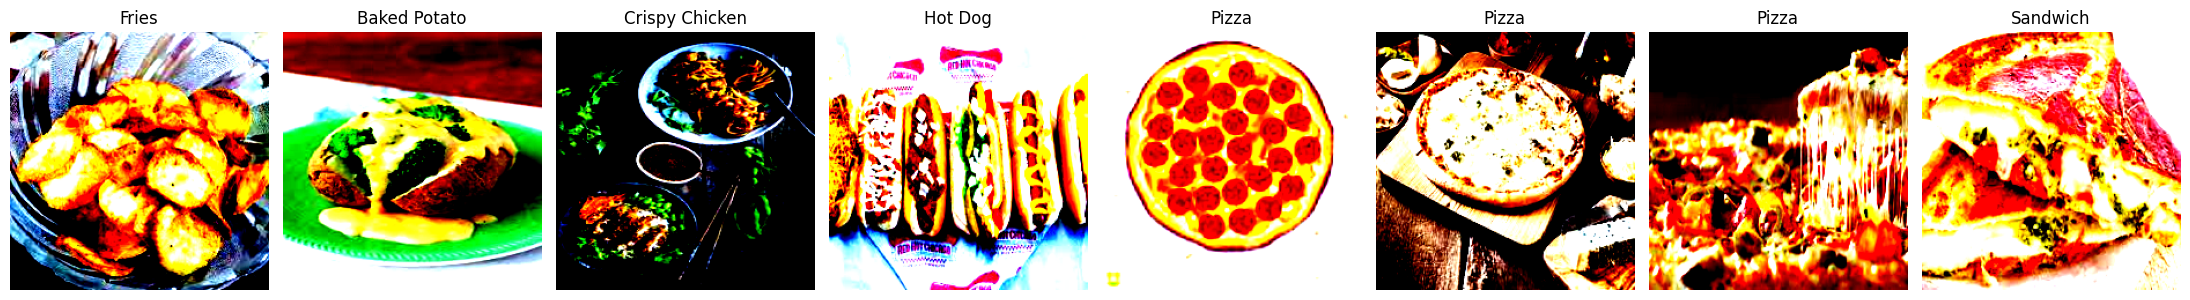

In [4]:
# Print some images
def show_images(images, labels, ncols=8):
    figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        ax.set_title(class_names[labels[i]])
        ax.axis("off")
    plt.tight_layout()

show_images(images, labels)

# Preprocess the data

In [5]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

mu, sigma = processor.image_mean, processor.image_std
size = processor.size
size

{'height': 224, 'width': 224}

In [6]:
# model1 = ViTForImageClassification.from_pretrained(model_name) #The google/vit-base-patch16-224 model is originally fine tuned on imagenet-1K with 1000 output classes
# print(model1.config)

model2 = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True) #We can change the number of output classes to 10
print(model2.config)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.47.1"


In [7]:

epochs = 10
lr = 1e-4
batch_size = 32

model = model2.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    # Train on batches of data
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        logits = outputs.logits # The logits are the output of the last linear layer
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = correct / total

    # Validation loop
    model.eval() # Set model to evaluation mode
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}/{epochs}"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    valid_accuracy = correct / total
    avg_valid_loss = valid_loss / len(valid_loader)


    # Log to console
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

Training Epoch 1/10:  75%|███████▌  | 354/469 [01:55<00:36,  3.14it/s]/home/rahi/miniconda3/envs/vit/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating Epoch 1/10: 100%|██████████| 110/110 [00:13<00:00,  8.14it/s]


Epoch 1/10, Train Loss: 0.3358, Train Acc: 0.9061, Valid Loss: 0.3300, Valid Acc: 0.9020


Validating Epoch 2/10: 100%|██████████| 110/110 [00:13<00:00,  8.08it/s]


Epoch 2/10, Train Loss: 0.1111, Train Acc: 0.9686, Valid Loss: 0.3249, Valid Acc: 0.9066


Validating Epoch 3/10: 100%|██████████| 110/110 [00:13<00:00,  8.19it/s]


Epoch 3/10, Train Loss: 0.0511, Train Acc: 0.9854, Valid Loss: 0.3363, Valid Acc: 0.9111


Validating Epoch 4/10: 100%|██████████| 110/110 [00:13<00:00,  8.16it/s]


Epoch 4/10, Train Loss: 0.0635, Train Acc: 0.9808, Valid Loss: 0.3910, Valid Acc: 0.8994


Training Epoch 5/10:  13%|█▎        | 60/469 [00:19<02:15,  3.01it/s]


KeyboardInterrupt: 

# Evaluate the model

Evaluating on Test Set:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating on Test Set: 100%|██████████| 47/47 [00:06<00:00,  7.58it/s]


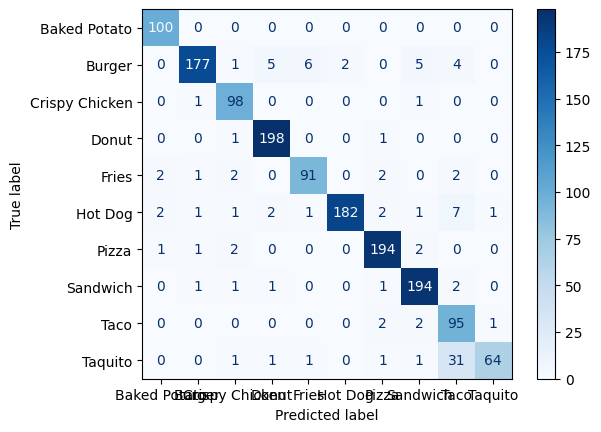

In [9]:
# Evaluate on the test set

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        logits = outputs.logits
        _, preds = torch.max(logits, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
class_names = test_dataset.classes

disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal', values_format=None)

# Print Classification Report
print("Classification Report:")
# print(classification_report(all_labels, all_preds, target_names=class_names))

# Visualize the test images with the predicted labels

In [ ]:
def show_test_images_with_predictions(images, labels, preds, class_names, ncols=8):
    figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert from CxHxW to HxWxC and move to CPU
        ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        ax.axis("off")
    plt.tight_layout()

# Get a batch of test images and labels
test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)

# Get predictions for the batch
with torch.no_grad():
    outputs = model(test_images)
    _, test_preds = torch.max(outputs.logits, 1)

# Show the images with true and predicted labels
show_test_images_with_predictions(test_images, test_labels, test_preds, class_names, ncols=18)

: 

In [13]:
# Save the model
model_path = "models/vit_fast_food_classifier.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/vit_fast_food_classifier.pth
